In [4]:
from pybit.unified_trading import HTTP
from dotenv import load_dotenv
import pandas as pd
import os

load_dotenv()

session = HTTP(
    testnet=False,
    api_key=os.getenv('API_KEY'),
    api_secret=os.getenv('API_SECRET'),
)



def fetch_market_data(symbol):
    data = session.get_kline(symbol=symbol, interval=60)

    df = pd.DataFrame(data['result']['list'])
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df.set_index('Date', inplace=True)

    df = df[::-1]
    return df

def calculate_indicators(df, window=14):
    #METHOD 1 RSI
    change = df["Close"].astype(float).diff()
    change.dropna(inplace = True)
    change_up = change.copy()
    change_down = change.copy()
    change_up[change_up<0]=0
    change_down[change_down>0]=0
    change.equals(change_up+change_down)
    avg_up = change_up.rolling(14).mean()
    avg_down = change_down.rolling(14).mean().abs()
    df['rsi'] = 100* avg_up/(avg_up+avg_down)



    #METHOD 2 RSI
  
    delta = df['Close'].astype(float).diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=12).mean()
    avg_loss = loss.rolling(window=12).mean()
    rs = avg_gain / avg_loss
    df['rsi2'] = 100 - (100 / (1 + rs))
    df['rsi_sma'] = df['rsi'].rolling(window=14).mean()



    # MACD

    df['EMA12']= df['Close'].astype(float).ewm(span=12).mean() #SHORT EMA
    df['EMA26']= df['Close'].astype(float).ewm(span=26).mean()  #LONG EMA
    df['macd']= df['EMA12']-df['EMA26']
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    
    return df
    
symbol = 'BTCUSDT'
data = fetch_market_data(symbol)
new = calculate_indicators(data)
display(new)


C:\Users\Eunha\AppData\Local\Temp/ipykernel_27748/2963017248.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['Date'] = pd.to_datetime(df['Date'], unit='ms')


,Open,High,Low,Close,Volume,Turnover,rsi,rsi2,rsi_sma,EMA12,EMA26,macd,macd_signal
Date,,,,,,,,,,,,,
2025-01-09 06:00:00,94438.7,94588.6,94001,94052.3,1813.133,170971263.085,NaN,NaN,NaN,94052.300000,94052.300000,0.000000,0.000000
2025-01-09 07:00:00,94052.3,94264.7,93089.4,93175.6,5075.48,474934650.8119,NaN,NaN,NaN,93577.420833,93597.090385,-19.669551,-10.927528
2025-01-09 08:00:00,93175.6,93360,92705,92979.5,7271.242,676275395.19,NaN,NaN,NaN,93344.052194,93375.196156,-31.143962,-19.212952
2025-01-09 09:00:00,92979.5,93694.1,92916,93464.6,2829.436,264244859.7368,NaN,NaN,NaN,93382.104425,93400.189564,-18.085138,-18.830901
2025-01-09 10:00:00,93464.6,93623.1,92980.1,93416,2673.379,249351147.6681,NaN,NaN,NaN,93391.313732,93403.856069,-12.542337,-16.960196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17 09:00:00,102100,102269.3,101720,101833.4,2645.668,269881082.1533,65.578388,69.546720,63.600608,101163.219759,100465.554620,697.665139,592.557562
2025-01-17 10:00:00,101833.4,102579.3,101767.2,102315.8,3266.8,334006088.3772,69.794284,77.784341,64.722667,101340.539796,100602.609869,737.929927,621.632035
2025-01-17 11:00:00,102315.8,102436.9,102054.1,102205.4,1986.219,203070802.9025,70.945986,75.043224,66.048232,101473.595212,100721.335092,752.260119,647.757652


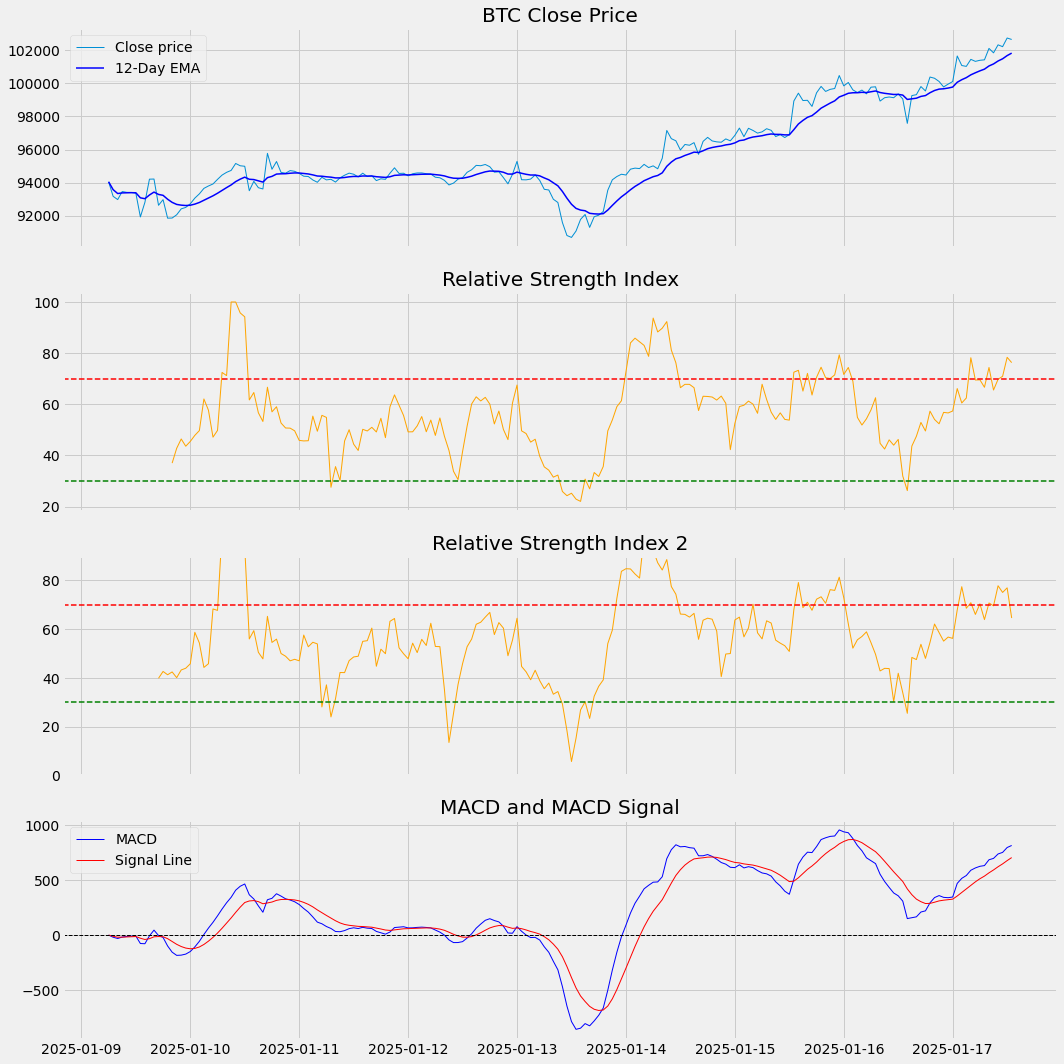

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 15)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15, 15))  



# First chart: Plot the closing price
ax1.plot(data['Close'].astype(float), label='Close price', linewidth=1)
ax1.plot(data['EMA12'], linewidth=1.5, label='12-Day EMA', color='blue')
ax1.set_title('BTC Close Price')
ax1.legend(loc='upper left')



# Second chart: Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(data['rsi'], color='orange', linewidth=1)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')  # Oversold level
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')    # Overbought level

#3
ax3.set_title('Relative Strength Index 2')
ax3.plot(data['rsi2'], color='orange', linewidth=1)
ax3.axhline(30, linestyle='--', linewidth=1.5, color='green')  # Oversold level
ax3.axhline(70, linestyle='--', linewidth=1.5, color='red')    # Overbought level


ax4.set_title('MACD and MACD Signal')
ax4.plot(data['macd'], label='MACD', color='blue', linewidth=1)
ax4.plot(data['macd_signal'], label='Signal Line', color='red', linewidth=1)
ax4.axhline(0, linestyle='--', color='black', linewidth=1)  
ax4.legend(loc='upper left')


ax3.set_ylim(0, 90)  # You can adjust the upper limit (90) as needed



plt.tight_layout()  
plt.show()
